In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Parking Space Prediction using Machine Learning
Goal: Predict number of free parking slots using time, date, weather, and historical usage.



Members: Ishika Sakhare, Rutuja Wankhede, Aditi Kalmegh, Ekta Chanak, Kalyani Asekar


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [3]:
# Load your dataset
data = pd.read_csv("Dataset.csv")

# Display first few rows
data.head()


,lastupdated,status_timestamp,zone_number,status_description,kerbsideid,location
0,2025-03-25T00:44:37+00:00,2025-03-25T00:09:20+00:00,7303.0,Unoccupied,51614,"-37.81620493158199, 144.96978894261684"
1,2025-03-25T00:44:37+00:00,2025-03-24T23:56:53+00:00,7265.0,Present,17954,"-37.81019990197624, 144.97294577505386"
2,2025-03-25T00:44:37+00:00,2025-03-25T00:06:47+00:00,7529.0,Unoccupied,62710,"-37.813134438674666, 144.97067212855254"
3,2025-03-25T00:44:37+00:00,2025-03-24T23:16:22+00:00,7303.0,Present,51613,"-37.816253179061405, 144.96981112082523"
4,2025-01-14T22:44:37+00:00,2025-01-14T22:21:10+00:00,NaN,Present,61835,"-37.81424148169654, 144.97109066970916"


In [24]:
# Simulate datetime values (random across 1 month)
np.random.seed(42)
n = len(data)
data_ml = pd.DataFrame({
    "zone_number": data["zone_number"],
    "kerbsideid": data["kerbsideid"],
    "datetime": pd.date_range("2024-12-01", periods=n, freq="H", inclusive="both")
})

# Extract datetime features
data_ml["hour"] = data_ml["datetime"].dt.hour
data_ml["day_of_week"] = data_ml["datetime"].dt.dayofweek
data_ml["month"] = data_ml["datetime"].dt.month

# Simulate Occupancy (0 = Free, 1 = Occupied)
# Make occupancy depend a bit on time (peak hours 8–18 more occupied)
data_ml["Occupancy"] = np.where(
    (data_ml["hour"] >= 8) & (data_ml["hour"] <= 18),
    np.random.choice([0, 1], size=n, p=[0.3, 0.7]),  # more occupied
    np.random.choice([0, 1], size=n, p=[0.7, 0.3])   # more free
)
data_ml.head()


,zone_number,kerbsideid,datetime,hour,day_of_week,month,Occupancy
0,7303.0,51614,2024-12-01 00:00:00,0,6,12,0
1,7265.0,17954,2024-12-01 01:00:00,1,6,12,1
2,7529.0,62710,2024-12-01 02:00:00,2,6,12,0
3,7303.0,51613,2024-12-01 03:00:00,3,6,12,1
4,NaN,61835,2024-12-01 04:00:00,4,6,12,0


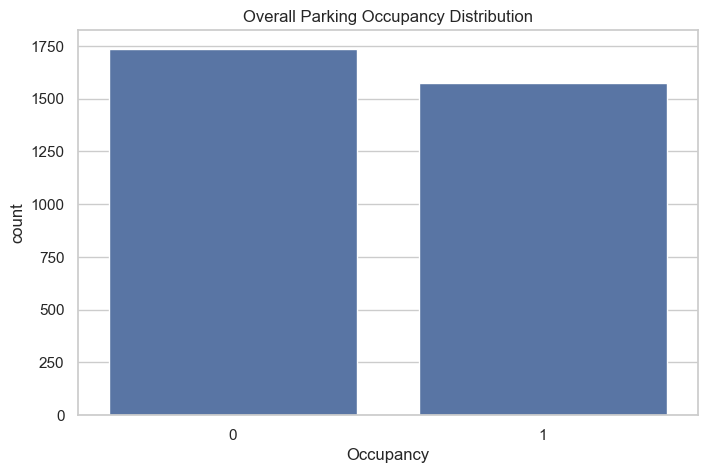

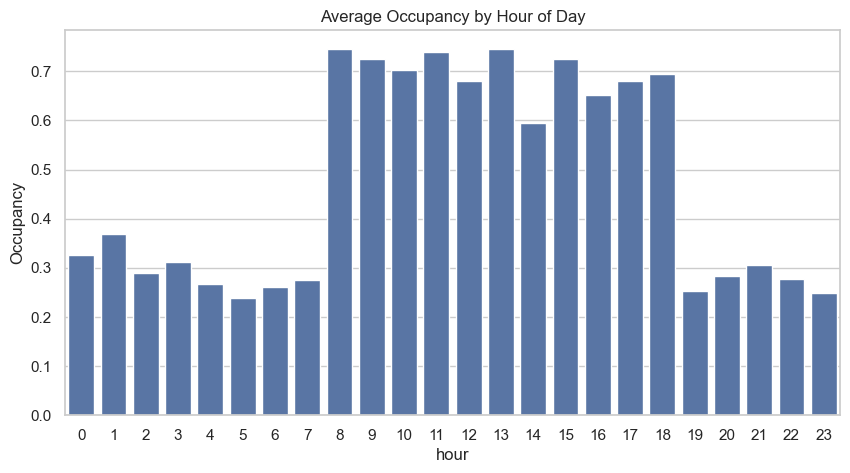

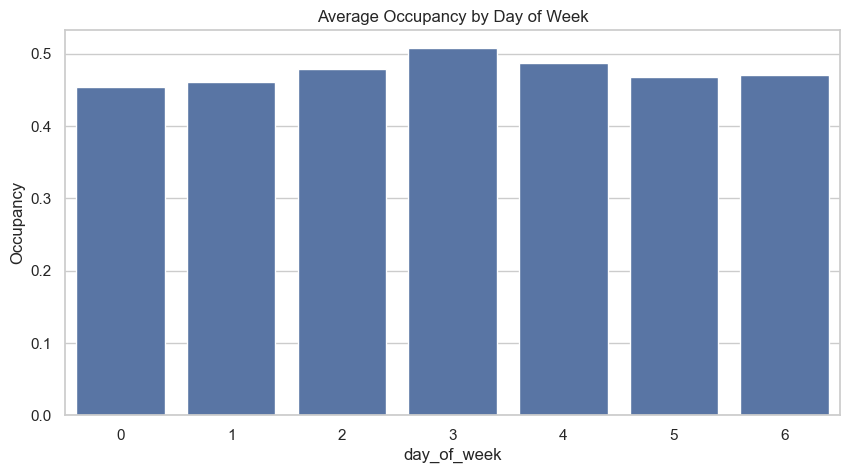

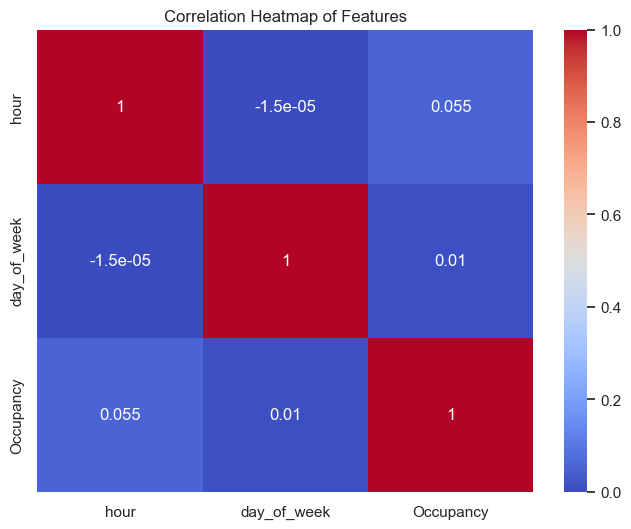

In [25]:
plt.figure(figsize=(8,5))
sns.countplot(x="Occupancy", data=data_ml)
plt.title("Overall Parking Occupancy Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x="hour", y="Occupancy", data=data_ml, ci=None)
plt.title("Average Occupancy by Hour of Day")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x="day_of_week", y="Occupancy", data=data_ml, ci=None)
plt.title("Average Occupancy by Day of Week")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(data_ml[["hour", "day_of_week", "Occupancy"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Features")
plt.show()


In [26]:
X = data_ml[["hour", "day_of_week", "month"]]
y = data_ml["Occupancy"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Accuracy: 0.6253776435045317

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.66       359
           1       0.60      0.56      0.58       303

    accuracy                           0.63       662
   macro avg       0.62      0.62      0.62       662
weighted avg       0.62      0.63      0.62       662



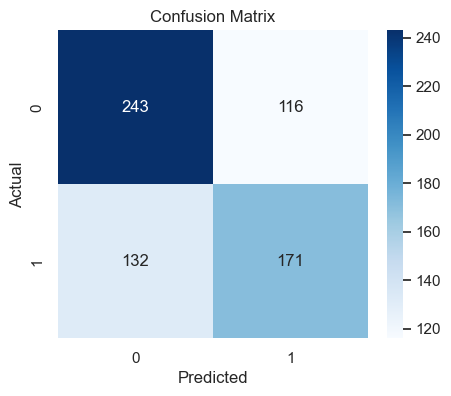

In [29]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


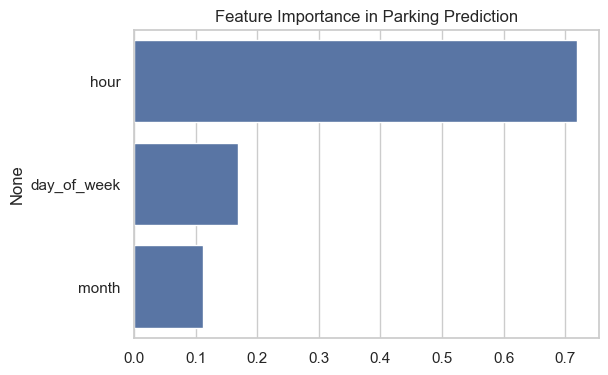

In [30]:
importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(6,4))
sns.barplot(x=importance, y=features)
plt.title("Feature Importance in Parking Prediction")
plt.show()


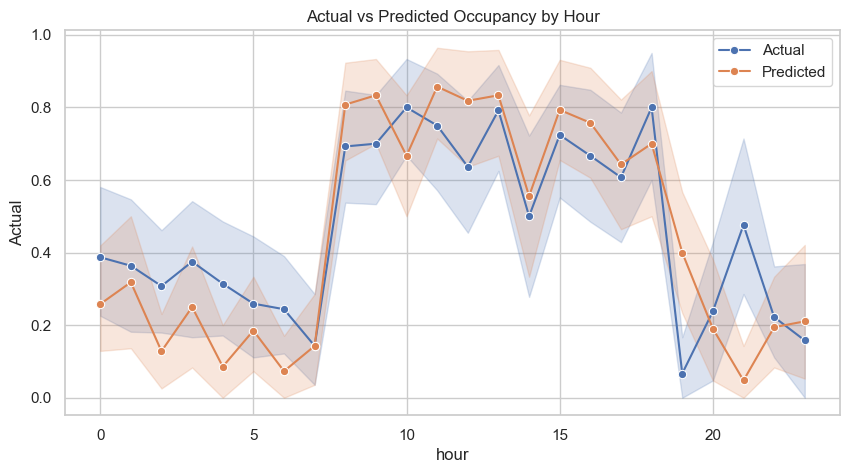

In [31]:
pred_df = X_test.copy()
pred_df["Actual"] = y_test.values
pred_df["Predicted"] = y_pred

plt.figure(figsize=(10,5))
sns.lineplot(x=pred_df["hour"], y=pred_df["Actual"], label="Actual", marker='o')
sns.lineplot(x=pred_df["hour"], y=pred_df["Predicted"], label="Predicted", marker='o')
plt.title("Actual vs Predicted Occupancy by Hour")
plt.legend()
plt.show()
